In [1]:
from keras import backend as K
from tensorflow.python.client import device_lib
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import pandas as pd
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import load_model
import keras
import matplotlib.pyplot as plt
import matplotlib



print(device_lib.list_local_devices())
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
D:\Programy\MyAnacondaDont\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Programy\MyAnacondaDont\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Programy\MyAnacondaDont\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Programy\MyAnacon

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16857467938295893800
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5085921280
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9900494521451828435
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

# _image_handler

In [2]:
## _image_handler
from skimage.io import *
from tensorflow.python.client import device_lib
from keras import backend as K
from skimage.util import img_as_ubyte
import cv2
import numpy as np
import os
import pandas as pd

def image_fromURL_toGrey(x, size, prnt, directory):
    # Here we read the file from the url, convert it to greyscale of size
    # given by the user, check if it's aviable and if it's not return nan
    # temp = np.array(x)
    dir = directory

    def applier(url, size2=size, shall_print=prnt):
        url2 = (url[:-4] + 'jpg').replace('html', 'detail')
        # img = Image.open(requests.get(url2, stream=True).raw).convert('L')
        try:
            tempname = url2.split('/')
            filename = tempname[-2] + '_' + tempname[-1]
            if os.path.isfile(dir + "/" + filename):
                return filename
            if shall_print:
                img1 = imread(url2, as_gray=False)
                img1 = cv2.resize(img1, (size2, size2), interpolation=cv2.INTER_CUBIC)
                img1 = img_as_ubyte(img1)
                imsave(dir + "/" + filename, img1)
            if os.path.isfile(dir + "/" + filename):
                return filename
            else:
                return np.nan
        except Exception as e:
            # print(e)
            return np.nan

    # print(temp)
    return np.vectorize(applier)(x)


#
def putImageToDb_CV2(x, directory):
    # @numba.jit
    def applier(url):
        url2 = (url[:-4] + 'jpg').replace('html', 'detail')
        dir = directory
        tempname = url2.split('/')
        filename = tempname[-2] + '_' + tempname[-1]
        try:
            image = cv2.imread(dir + '/' + filename)
            return image
        except:
            return np.nan

    return np.vectorize(applier)(x)


#  _database


In [3]:
##--------------- _database
import pandas as pd
import numpy as np
import os
import sys
import swifter

def createImageDatabase(dir, im_dir, download=False, want_whole_im=False, howmany=20000):
    db = pd.read_excel(dir, nrows=howmany)
    db['URL'] = db['URL'].where(db['URL'].str.endswith('html')).dropna()
    # db['URL'] = db.swifter.apply(lambda x: image_fromURL_toGrey(x['URL'], 128), axis=1, raw=True)
    if not want_whole_im:
        if download or len(os.listdir(im_dir)) == 0:
            # we put files into database, if the files are downloaded yet we can skip it
            print('Downloading files and saving them in ' + im_dir + '\n')
            db['URL'] = db['URL'].swifter.apply(image_fromURL_toGrey, args=[128, True, im_dir])

        else:
            # we print the files to the folder, and put them into database, if the files are downloaded yet we can
            # skip it
            print('Taking files and just putting their names in the dataframe\n')
            db['URL'] = db['URL'].swifter.apply(image_fromURL_toGrey, args=[128, False, im_dir])
        db = (db.dropna()
              .rename(columns={'URL': 'Images'}))
    else:
        print('Putting images from folder ' + im_dir + ' to dataframe\n')
        db['Image'] = (db['URL'].swifter.apply(putImageToDb_CV2, args=[im_dir])
                       .dropna())
    print('Finished checking folder\n')
    db['ID'] = db.groupby(['TYPE']).ngroup()
    # print(db)
    # db.set_index('Images', inplace=True)
    return db

# _network
#

In [4]:
def printHistory(history):
    #val_acc = history.history['val_acc']
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    #plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



In [5]:
from keras.applications import VGG16
from keras.applications import VGG19
def createModel(df, dir, savename, columns,types_num, epo=10, batch=32):
    DATASET_LOCATION = dir
    BATCH_SIZE = batch
    IMAGE_SIZE = (128, 128)
    INPUT_SHAPE = (128, 128, 3)
    EPOCHS = epo
    conv_base = VGG19(weights = 'imagenet', include_top=False, input_shape = (128, 128, 3))
    conv_base.trainable = False
    # Tworzymy bazę na podstawie conv modelu bez górnego klasyfikatora
    
    # Instantiating a Convolutional Neural Network (CNN) Classifier
    model = Sequential()
    # biggest -----------
    #--------vectoor
    for layer in conv_base.layers:
        layer.trainable = False
    # ------frozen base-------------
    model.add(conv_base)
    
    #model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu', input_shape=INPUT_SHAPE))
    #model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu'))
    #model.add(MaxPooling2D(2, 2))
    #model.add(Conv2D(64, (3, 3), activation= 'relu',padding='same'))
    #model.add(Conv2D(64, (3, 3), activation= 'relu',padding='same'))
    #model.add(MaxPooling2D(2, 2))

    #model.add(Conv2D(128, (3, 3), activation='relu'))
    #model.add(MaxPooling2D(2, 2))
    # conv_base.summary()
    
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    #model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(types_num, activation='softmax'))

    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.adam(),
        metrics=["accuracy"],
    )
    print('Initialized model\n')
    # separate in training and testing
    train_df, test_df = train_test_split(df, test_size=0.25, random_state=40)
    # data augmentation - to provide more samples
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
    )
    # cannot change validation data!
    test_datagen = ImageDataGenerator(rescale=1./255) 
    print('Created data augmentation method, now we have more data! Cool huh?\n')
    # read files of a difrectory using flow from dataframe
    # FIRST FOR TRAIN SECOND FOR TEST
    try:
        train_generator = train_datagen.flow_from_dataframe(
            train_df,
            DATASET_LOCATION,
            x_col=columns[0],
            y_col=columns[1],
            target_size=IMAGE_SIZE,
            class_mode="categorical",
            batch_size=BATCH_SIZE,
        )
        print('Created set for teaching\n')
        test_generator = test_datagen.flow_from_dataframe(
            test_df,
            DATASET_LOCATION,
            x_col=columns[0],
            y_col=columns[1],
            target_size=IMAGE_SIZE,
            class_mode="categorical",
            batch_size=BATCH_SIZE,
        )
        print('Created set for validation\n')
        # NOW WE TRAIN THE MODEL
        history = model.fit_generator(
            train_generator,
            epochs=EPOCHS,
            validation_data=test_generator,
            validation_steps=test_df.shape[0] // BATCH_SIZE,
            steps_per_epoch=train_df.shape[0] // BATCH_SIZE,
            verbose=1,
        )
        print('Trained frozen model. Now unfroze some\n')
        set_trainable = False
        for layer in conv_base.layers:
            if layer.name == 'block5_conv1':
                set_trainable = True
            if set_trainable:
                layer.trainable = True
            else:
                layer.trainable = False
                
            
        model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.RMSprop(lr=1e-5),
        metrics=["accuracy"],
        )
                
        history = model.fit_generator(
            train_generator,
            epochs=EPOCHS,
            validation_data=test_generator,
            validation_steps=test_df.shape[0] // BATCH_SIZE,
            steps_per_epoch=train_df.shape[0] // BATCH_SIZE,
            verbose=1,
        )
        
        
        
        print('Trained model\n')
        # save model and architecture to single file
        model.save(savename)
        print("Saved model to disk\n")
        return history
    except Exception as e:
        print(e)





In [6]:
def testModel(test_df, test_dir, name, columns):
    IMAGE_SIZE = (128, 128)
    INPUT_SHAPE = (128, 128, 3)
    # load model
    model = load_model(name)
    print('Loaded the model\n')
    # summarize model.
    model.summary()
    # test generator
    batches = 1
    sample_test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
        test_df,
        test_dir,
        x_col=columns[0],
        y_col=columns[1],
        target_size=IMAGE_SIZE,
        class_mode="categorical",
        #batch_size=batches,
    )
    label_map = (sample_test_generator.class_indices)
    print('Created test generator\n')
    # predict
    filenames = sample_test_generator.filenames
    nb_samples = len(filenames)
    #print('Len of filenames is:' + nb_samples)
    predict = model.predict_generator(sample_test_generator,np.ceil(nb_samples/batches))
    return predict, label_map
    # score = model.evaluate_generator(sample_test_generator)
    # print("Accuracy = ", score[1]*100, '%')

# main

In [7]:
dir = 'D:/Uni/SEMESTERS/MS/II/MonographicComputation/LAB/Paintings/catalogMy.xlsx'
test_dir = 'D:/Uni/SEMESTERS/MS/II/MonographicComputation/LAB/Paintings/new.xlsx'
learnImDir = 'D:/Uni/SEMESTERS/MS/II/MonographicComputation/LAB/Paintings/Images'
testImDir = 'D:/Uni/SEMESTERS/MS/II/MonographicComputation/LAB/Paintings/ImagesTest'

In [ ]:
testPd = createImageDatabase(test_dir, testImDir, True, howmany = 2000)
learnPd = createImageDatabase(dir, learnImDir, False, howmany = 10000)



Finished checking folder

Taking files and just putting their names in the dataframe



In [9]:
train_cols = ['Images','FORM']

print('Learn df is :\n', learnPd[['Images', train_cols[1], 'ID']].head(20))
print('Test df is :\n', testPd[['Images', train_cols[1], 'ID']].head(20))

Learn df is :
                   Images      FORM  ID
0    aachen_j_couple.jpg  painting   0
1    aachen_k_couple.jpg  painting   0
2    aachen_portrai4.jpg  painting   0
3     aachen_z_scene.jpg  painting   0
4         adam1_hunt.jpg  painting   0
5       aertsen_cook.jpg  painting   0
6      aertsen_cook1.jpg  painting   0
7   aertsen_egg-danc.jpg  painting   0
8     aertsen_market.jpg  painting   0
9    aertsen_market1.jpg  painting   0
10  aertsen_marketsc.jpg  painting   0
11  aertsen_marketsd.jpg  painting   0
12  aertsen_meatsell.jpg  painting   0
13  aertsen_merry_co.jpg  painting   0
14   aertsen_pancake.jpg  painting   0
15  aertsen_peasant1.jpg  painting   0
16  aertsen_peasant2.jpg  painting   0
17  aertsen_vendor_f.jpg  painting   0
18   agasse_playgrou.jpg  painting   0
19     aken_conversa.jpg  painting   0
Test df is :
                    Images          FORM  ID
0     mochi_o_players.jpg     sculpture   0
1    cordier_sterling.jpg     sculpture   1
2          1_211giam

In [25]:
db = learnPd.loc[:,train_cols]
db['ID'] = db.groupby(train_cols[1]).ngroup()
print(db.head())
dic = (db.groupby(train_cols[1]).first())['ID'].to_dict()
print(dic)
types_num = len(dic)

                Images      FORM  ID
0  aachen_k_couple.jpg  painting   9
1  aachen_portrai4.jpg  painting   9
2  aachen_j_couple.jpg  painting   9
3   aachen_z_scene.jpg  painting   9
4  aachen_davidbat.jpg  painting   9
{'architecture': 0, 'ceramics': 1, 'furniture': 2, 'glassware': 3, 'graphics': 4, 'illumination': 5, 'metalwork': 6, 'mosaic': 7, 'others': 8, 'painting': 9, 'sculpture': 10, 'stained-glass': 11, 'tapestry': 12}


In [1]:
# create model
# history = createModel(learnPd, learnImDir,'from_imagenet_FORM.h5',train_cols,types_num, epo=10, batch=40)

NameError: name 'createModel' is not defined

No handles with labels found to put in legend.


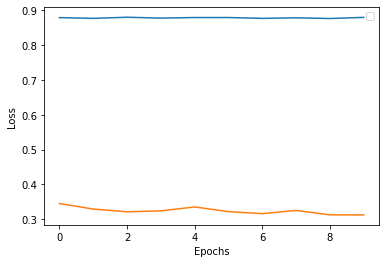

In [85]:
printHistory(history)

In [ ]:
predict, label_map_test = testModel(testPd, testImDir,'from_imagenet_FORM.h5',train_cols )

D:\Programy\MyAnacondaDont\envs\tf-gpu-cuda8\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Loaded the model

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_21 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_79 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dense_80 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_81 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_82 (Dense)             (None, 13)                845       
Total params: 24,367,821
Trainable params: 13,782,669
Non-trainable params: 10,585,152
______________

In [30]:
# check the indices and their categories on original dataset
def check_orig_labels(learnPd, learnImDir ):
    train_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
            learnPd,
            learnImDir,
            x_col=train_cols[0],
            y_col=train_cols[1],
            target_size=(128,128,3),
            class_mode="categorical",
        )
    return (train_generator.class_indices)
label_map_orig = check_orig_labels(learnPd, learnImDir)

Found 9994 validated image filenames belonging to 13 classes.


D:\Programy\MyAnacondaDont\envs\tf-gpu-cuda8\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="Images". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
print(label_map_orig)
print(label_map_test)

In [32]:
def change_keys_from_org_to_new(label_map_orig,label_map_test):
    res = {} 
    for key, val in label_map_orig.items():
        #label_map_test[key] = label_map_orig[key]
        res[val] = key
    print(label_map_orig,label_map_test)
    return res

final_dic = change_keys_from_org_to_new(label_map_orig,label_map_test  )

{'architecture': 0, 'ceramics': 1, 'furniture': 2, 'glassware': 3, 'graphics': 4, 'illumination': 5, 'metalwork': 6, 'mosaic': 7, 'others': 8, 'painting': 9, 'sculpture': 10, 'stained-glass': 11, 'tapestry': 12} {'architecture': 0, 'ceramics': 1, 'furniture': 2, 'glassware': 3, 'graphics': 4, 'illumination': 5, 'metalwork': 6, 'mosaic': 7, 'others': 8, 'painting': 9, 'sculpture': 10, 'stained-glass': 11, 'tapestry': 12}


In [33]:
print(final_dic)

{0: 'architecture', 1: 'ceramics', 2: 'furniture', 3: 'glassware', 4: 'graphics', 5: 'illumination', 6: 'metalwork', 7: 'mosaic', 8: 'others', 9: 'painting', 10: 'sculpture', 11: 'stained-glass', 12: 'tapestry'}


In [ ]:
test_check = testPd.loc[:,train_cols]
test_check['ID'] = test_check.groupby(train_cols[1]).ngroup()

max_index = np.argmax(predict, axis=1)     
print(max_index)
test_check['INDEX_PREDICTED'] = max_index

test_check['CATEGORY_PREDICTED'] = test_check['INDEX_PREDICTED'].map(lambda a: final_dic[a])

good_checks = test_check[test_check['FORM'] == test_check['CATEGORY_PREDICTED']]
print(test_check)